# Hierarchical Inference with Redshifts

This notebook builds on the results from 2.2 to develop some more complex hierarchical models.

# Setup

In [1]:
from __future__ import print_function, division
import sys
import pickle
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
from six.moves import range

# import frankenz code
import frankenz

# plot in-line within the notebook
%matplotlib inline

np.random.seed(7)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

# Data

For our proof-of-concept tests, we will use the mock SDSS data we previously generated and utilized in 2.1 and 2.2.

In [3]:
downsample = 10  # downsampling the population
survey = pickle.load(open('../data/mock_sdss_polletta_bpz.pkl', 'rb'))  # load data
types = survey.data['types'][::downsample]
templates = survey.data['templates'][::downsample]
redshifts = survey.data['redshifts'][::downsample]
mags = survey.data['refmags'][::downsample]
Nobs = len(types)

# Previous Results

Let's quickly re-generate our previous results.

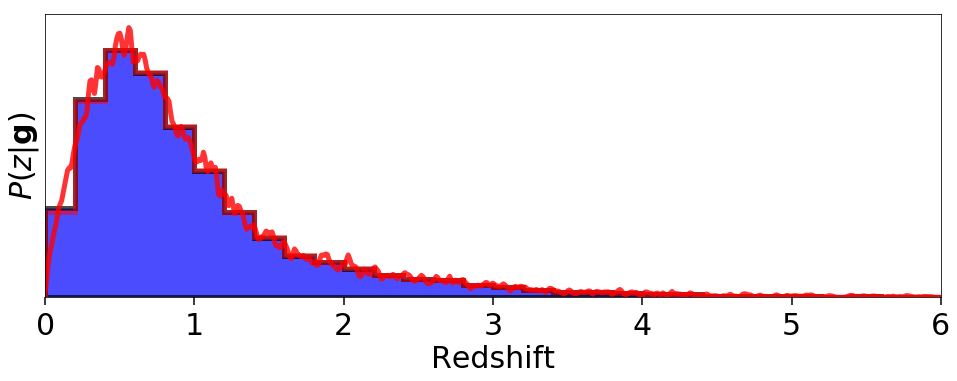

In [4]:
# bins
zbins = np.arange(0, 6.+1e-5, 0.2)  # redshift bins

# KDE
zgrid = np.arange(-1., 7.+1e-5, 0.01)  # redshift grid
Ngrid, sgrid = len(zgrid), 0.01
pdf = frankenz.pdf.gauss_kde(redshifts, np.ones(Nobs) * sgrid, zgrid)
pdf /= np.trapz(pdf, zgrid)

# plotting
plt.figure(figsize=(14, 6))
nz, _, _ = plt.hist(redshifts, bins=zbins, histtype='stepfilled', lw=5,
                    color='blue', alpha=0.7, normed=True, edgecolor='black')
plt.plot(zgrid, pdf, lw=5, color='red', alpha=0.8)
plt.hist(zgrid + 1e-5, bins=zbins, weights=pdf, histtype='step', lw=5,
         color='red', alpha=0.5, normed=True)
plt.xlabel('Redshift')
plt.xlim([zbins[0], zbins[-1]])
plt.yticks([])
plt.ylabel('$P(z|\mathbf{g})$')
plt.tight_layout()

In [5]:
# generate PDFs
sigma = np.random.uniform(0.05, 0.2, size=Nobs)  # width
mu = np.random.normal(redshifts, sigma)  # noisy observation
zpdf = np.array([frankenz.pdf.gaussian(mu[i], sigma[i], zgrid) 
                 for i in range(Nobs)])  # redshift pdfs
zpdf /= np.trapz(zpdf, zgrid)[:,None]  # normalizing

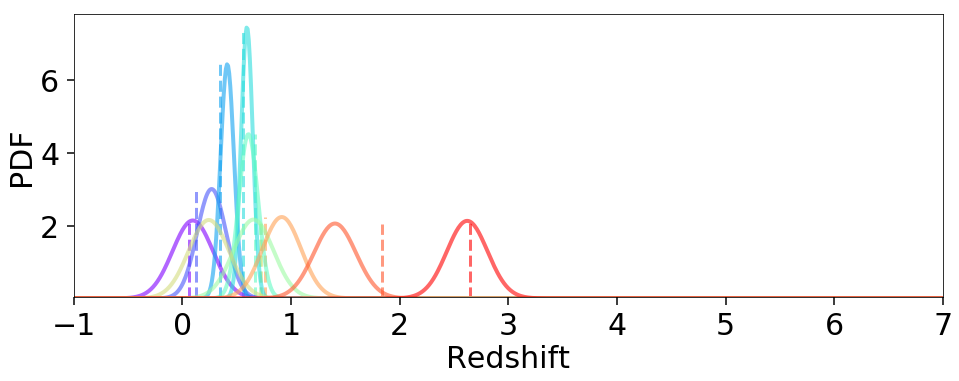

In [6]:
# plot some PDFs
plt.figure(figsize=(14, 6))
Nplot = 10
colors = plt.get_cmap('rainbow')(np.linspace(0., 1., Nplot))
zidxs = np.random.choice(Nobs, size=Nplot)
zidxs = zidxs[np.argsort(redshifts[zidxs])]
for i, c in zip(zidxs, colors):
    plt.plot(zgrid, zpdf[i], color=c, lw=4, alpha=0.6)
    plt.vlines(redshifts[i], 0., max(zpdf[i]), color=c, 
               lw=3, linestyles='--', alpha=0.6)
plt.xlim([zgrid[0], zgrid[-1]])
plt.ylim([0.03, None])
plt.xlabel('Redshift')
plt.ylabel('PDF')
plt.tight_layout()

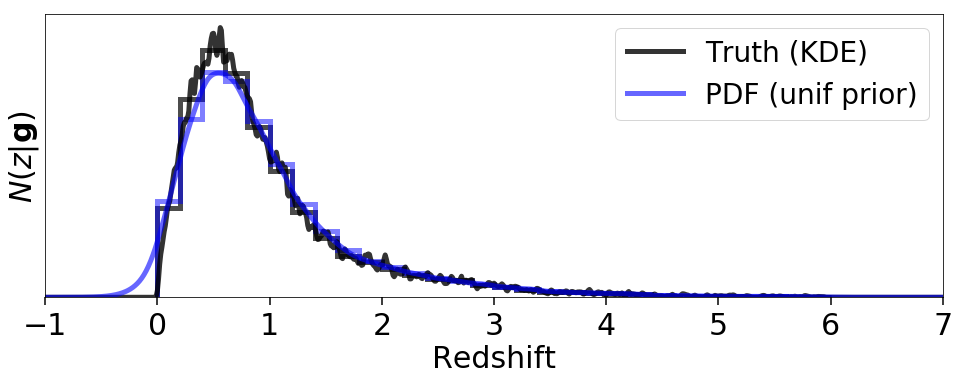

In [7]:
# plotting
plt.figure(figsize=(14, 6))
plt.plot(zgrid, pdf, lw=5, color='black', alpha=0.8,
         label='Truth (KDE)')
plt.plot(zgrid, zpdf.sum(axis=0) / Nobs, lw=5, color='blue',
         alpha=0.6, label='PDF (unif prior)')
plt.hist(redshifts, bins=zbins, histtype='step', lw=5,
         color='black', alpha=0.7, normed=True)
plt.hist(zgrid + 1e-5, bins=zbins, weights=zpdf.sum(axis=0) / Nobs,
         histtype='step', lw=5,
         color='blue', alpha=0.5, normed=True)
plt.xlabel('Redshift')
plt.xlim([zgrid[0], zgrid[-1]])
plt.yticks([])
plt.ylabel('$N(z|\mathbf{g})$')
plt.ylim([0., None])
plt.legend(fontsize=28, loc='best')
plt.tight_layout()

## Population Inference

In [8]:
# number of samples
Nsamples = 50

In [9]:
# draw Poisson samples
pdf1 = zpdf.sum(axis=0)  # stack PDFs
pdf1 /= pdf1.sum()  # normalize
pdf1 *= Nobs  # transform to counts
pdf1_samples = np.array([np.random.poisson(pdf1) 
                         for i in range(Nsamples)])  # draw samples

In [10]:
# draw multinomial samples
pdf2_samples = np.random.multinomial(Nobs, pdf1 / pdf1.sum(),
                                     size=Nsamples)  # samples

In [11]:
# draw posterior samples
pdf3_samples = np.zeros_like(pdf1_samples)
zpdf_norm = zpdf / zpdf.sum(axis=1)[:, None]
for j in range(Nsamples):
    sys.stderr.write(' {0}'.format(j))
    for i in range(Nobs):
        # stack categorial draw
        pdf3_samples[j] += np.random.multinomial(1, zpdf_norm[i])

 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49

## Hierarchical Modeling

In [12]:
# initialize concentration parameters
alpha = np.ones(Ngrid)
alpha[zgrid < 0.] = 1e-3

In [13]:
def mcmc_gibbs(pdfs, Nsamples, Ngrid,
               Nburn=0, Nthin=1, verbose=True):
    """Using MCMC with Gibbs sampling to sample from
    the joint distribution of our hierarchical model."""
    
    Nobs = len(pdfs)
    samples_pi = np.zeros((Nsamples, Ngrid))
    samples_n = np.zeros((Nsamples, Ngrid), dtype='int')

    prior = np.ones(Ngrid)  # initialize weights
    for j in range(Nthin * (Nsamples + Nburn)):
        count = int(j / Nthin) - Nburn
        if verbose and (j + 1) % Nthin == 0: 
            sys.stderr.write('{0} '.format(count))

        # Compute new posterior.
        nstack = np.zeros(Ngrid)
        pdf_t = pdfs * prior
        pdf_t /= pdf_t.sum(axis=1)[:, None]

        # Stack posterior.
        for i in range(Nobs):
            nstack += np.random.multinomial(1, pdf_t[i])

        # Sample population weights.
        prior = np.random.dirichlet(nstack + alpha) * Nobs

        # Save samples.
        if (j + 1) % Nthin == 0 and count >= 0:
            samples_n[count] = nstack.copy()
            samples_pi[count] = prior.copy()
            
    return samples_n, samples_pi

In [14]:
# sample from our hierarchical model
pdf4_samples_n, pdf4_samples_pi = mcmc_gibbs(zpdf, Nsamples, Ngrid,
                                             Nburn=50, Nthin=10)

-50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

## Results

In [15]:
def zplot(samples, label='type', color='blue'):
    """Plot our draws."""
    
    [plt.plot(zgrid, samples[i], lw=2, color=color, alpha=0.07)
     for i in range(Nsamples)]
    plt.plot(zgrid, pdf/pdf.sum() * Nobs, lw=5, color='black',
             alpha=0.7)
    plt.plot(zgrid, pdf * 0.0 - 1e4, lw=3, color=color,
             alpha=0.5, label=label)
    plt.xlabel('Redshift')
    plt.xlim([zgrid[0], zgrid[-1]])
    plt.yticks([])
    plt.ylim([0, max(pdf / pdf.sum() * Nobs) * 1.2])
    plt.ylabel('$N(z|\mathbf{g})$')
    plt.legend(fontsize=26, loc='best')
    plt.tight_layout()

In [16]:
def zplot_bin(samples, label='type', color='blue', binning=5):
    """Plot our binned draws."""
    [plt.hist(zgrid + 1e-5, zgrid[::binning], 
              weights=samples[i], lw=3,
              histtype='step', color=color, alpha=0.15) 
     for i in range(Nsamples)]
    plt.hist(zgrid, weights=pdf*1e-5, lw=3, histtype='step',
             color=color, alpha=0.6, label=label)
    h = plt.hist(redshifts, zgrid[::binning], 
                 histtype='step', lw=6, color='black', alpha=0.7)
    plt.xlabel('Redshift')
    plt.xlim([zgrid[0], zgrid[-1]])
    plt.yticks([])
    plt.ylim([0, max(h[0]) * 1.2])
    plt.ylabel('$N(z|\mathbf{g})$')
    plt.legend(fontsize=26, loc='best')
    plt.tight_layout()

In [17]:
def cov_draws(samples, bin1=(60, 80), bin2=(80, 100), color='blue', 
              label='label', xlim=None, ylim=None):
    """Plot our draws within two bins."""

    # Bin results.
    n, _ = np.histogram(redshifts, bins=zgrid)
    pdf_bin1 = n[bin1[0]:bin1[1]].sum() / n.sum() * Nobs / 1e3
    pdf_bin2 = n[bin2[0]:bin2[1]].sum() / n.sum() * Nobs / 1e3
    samples_bin1 = samples[:, bin1[0]:bin1[1]].sum(axis=1) / 1e3
    samples_bin2 = samples[:, bin2[0]:bin2[1]].sum(axis=1) / 1e3
    
    # Plot results.
    plt.vlines(pdf_bin1, 0, 100, lw=2, colors='black', linestyles='--')
    plt.hlines(pdf_bin2, 0, 100, lw=2, colors='black', linestyles='--')
    plt.plot(pdf_bin1, pdf_bin2, 's', color='black', markersize=20)
    plt.plot(samples_bin1, samples_bin2, 'o', color=color, 
             label=label, markersize=15, alpha=0.6)
    if xlim is None:
        plt.xlim([min(pdf_bin1, min(samples_bin1)) - 0.1, 
                  max(pdf_bin1, max(samples_bin1)) + 0.1])
    else:
        plt.xlim(xlim)
    if ylim is None:
        plt.ylim([min(pdf_bin2, min(samples_bin2)) - 0.1, 
                  max(pdf_bin2, max(samples_bin2)) + 0.1])
    else:
        plt.ylim(ylim)
    plt.xlabel(r'$N({0}\leq z < {1}) \quad [10^3]$'.format(zgrid[bin1[0]], 
                                                           zgrid[bin1[1]]))
    plt.ylabel(r'$N({0}\leq z < {1}) \quad [10^3]$'.format(zgrid[bin2[0]], 
                                                           zgrid[bin2[1]]))
    plt.legend(fontsize=28, loc=1)
    plt.tight_layout()

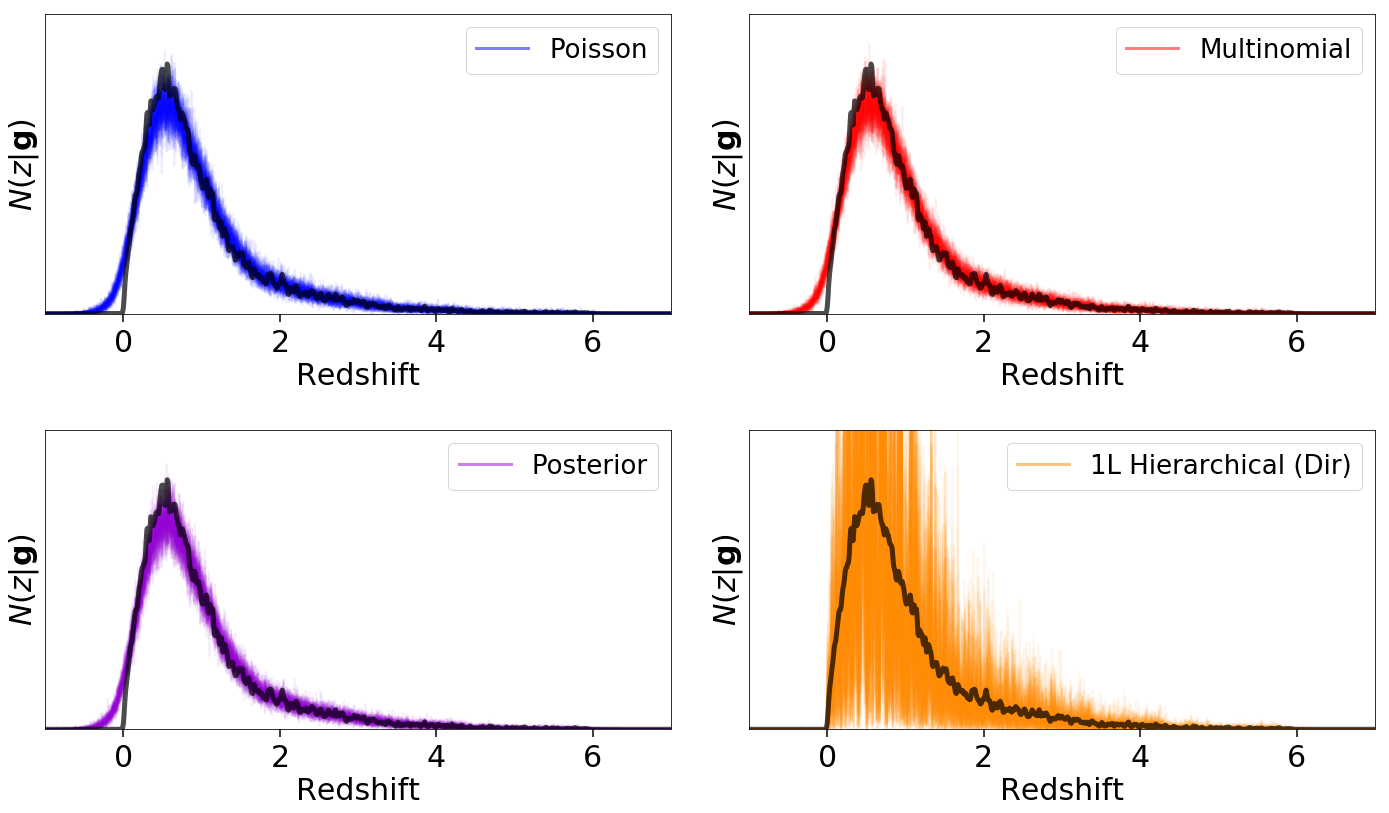

In [18]:
# plotting
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
zplot(pdf1_samples, label='Poisson', color='blue')
plt.subplot(2, 2, 2)
zplot(pdf2_samples, label='Multinomial', color='red')
plt.subplot(2, 2, 3)
zplot(pdf3_samples, label='Posterior', color='darkviolet')
plt.subplot(2, 2, 4)
zplot(pdf4_samples_n, label='1L Hierarchical (Dir)', color='darkorange')

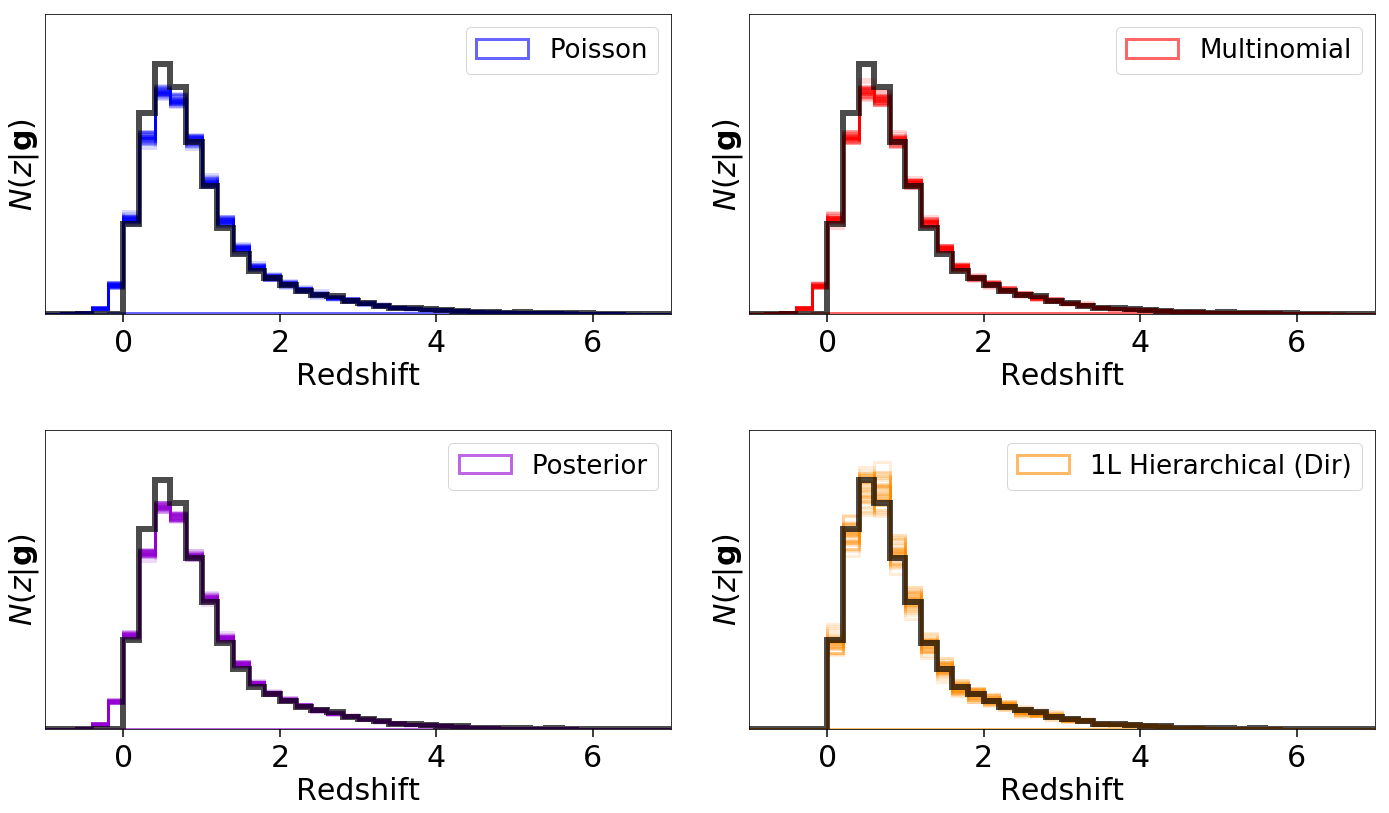

In [19]:
# plotting binned results
plt.figure(figsize=(20, 12))
plt.subplot(2, 2, 1)
zplot_bin(pdf1_samples, label='Poisson', color='blue', binning=20)
plt.subplot(2, 2, 2)
zplot_bin(pdf2_samples, label='Multinomial', color='red', binning=20)
plt.subplot(2, 2, 3)
zplot_bin(pdf3_samples, label='Posterior', color='darkviolet', binning=20)
plt.subplot(2, 2, 4)
zplot_bin(pdf4_samples_n, label='1L Hierarchical (Dir)', color='darkorange', binning=20)

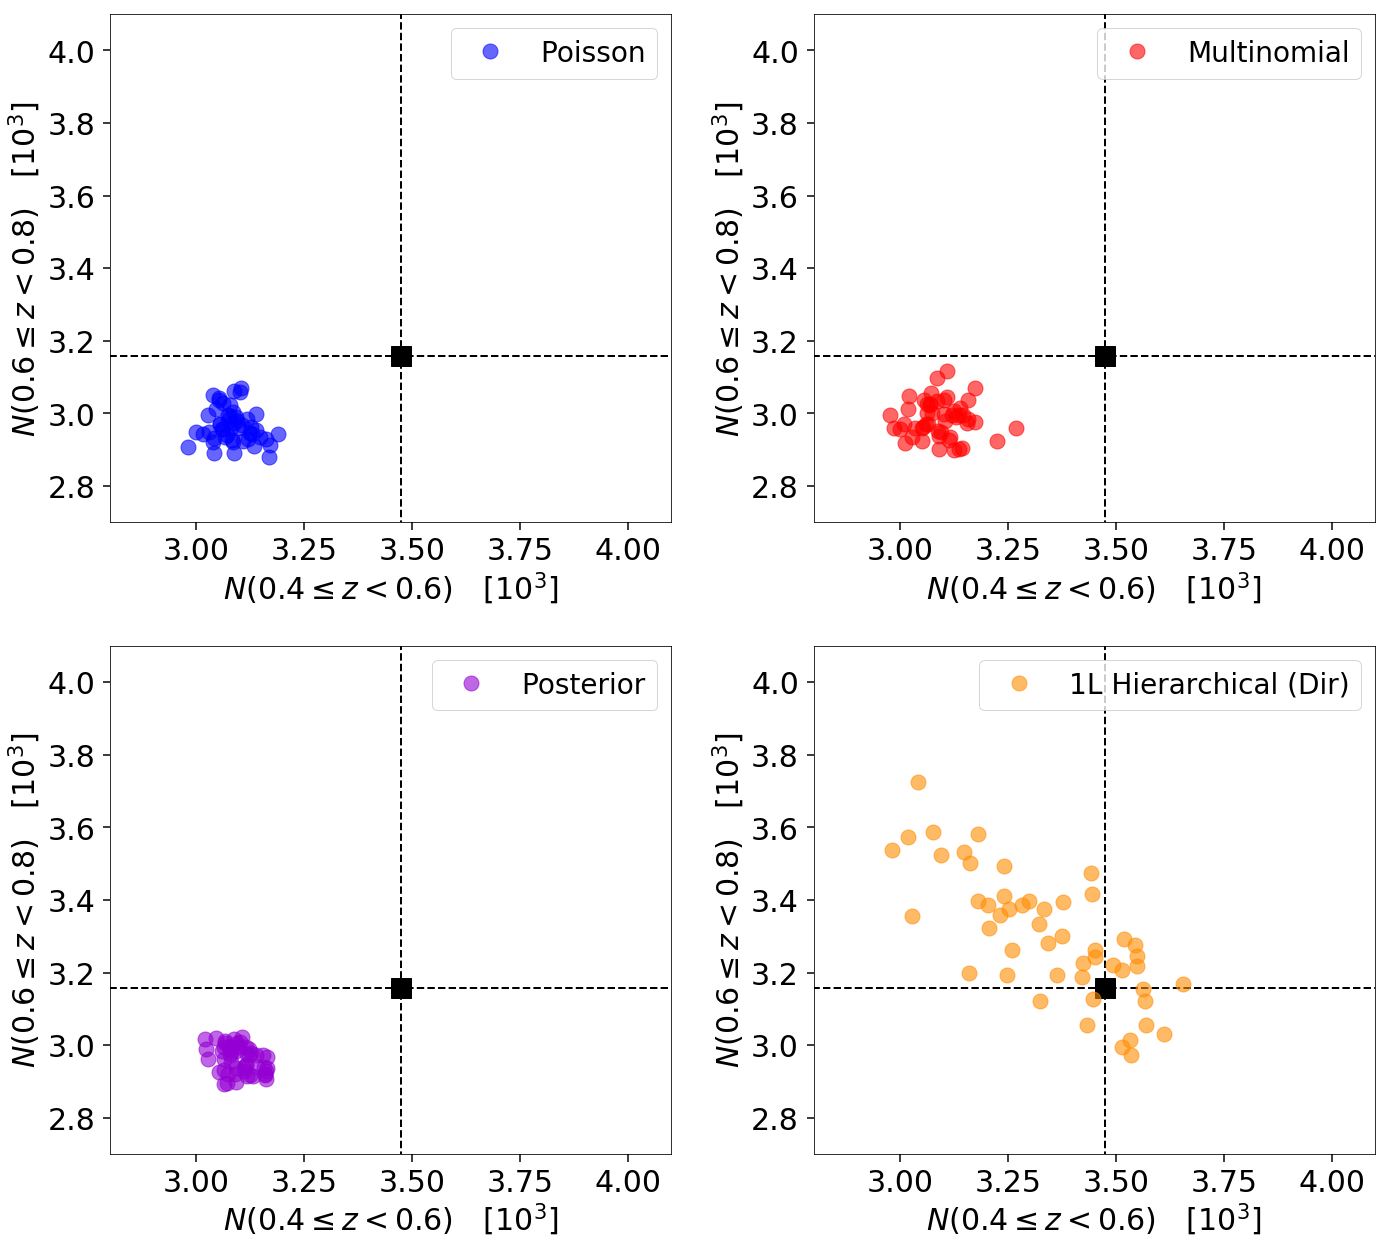

In [20]:
# plotting binned covariance
plt.figure(figsize=(20,18))
plt.subplot(2,2,1)
cov_draws(pdf1_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.8, 4.1), ylim=(2.7, 4.1),
          color='blue', label='Poisson')
plt.subplot(2,2,2)
cov_draws(pdf2_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.8, 4.1), ylim=(2.7, 4.1),
          color='red', label='Multinomial')
plt.subplot(2,2,3)
cov_draws(pdf3_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.8, 4.1), ylim=(2.7, 4.1),
          color='darkviolet', label='Posterior')
plt.subplot(2,2,4)
cov_draws(pdf4_samples_n, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.8, 4.1), ylim=(2.7, 4.1),
          color='darkorange', label='1L Hierarchical (Dir)')

# 2-Level Weibull-Dirichlet Hierarchical Model

Up until now, we've only explored the simplest of hierarchical models: a 1-level Dirichlet hierarchical model. While our results from above show that they appear to work reasonably well, we want to explore more complex examples where we try and learn more structure.

In this first case, we now want to impose a prior over $\boldsymbol{\alpha}$ and sample from the joint distribution $P(\mathbf{n}_\mathbf{g}, \boldsymbol{\pi}_\mathbf{g}, \boldsymbol{\alpha}|\boldsymbol{\phi})$. This allows the "pseudo-counts" imposed by $\boldsymbol{\alpha}$ to vary. 

Why should we try and do inference over $\boldsymbol{\alpha}$? Well, our prior weights $\boldsymbol{\pi}_\mathbf{g}$ are conditionaly distributed as

$$ \boldsymbol{\pi}_\mathbf{g}^{(i)}|\mathbf{n}_\mathbf{g}^{(i)},\boldsymbol{\alpha}^{(i-1)} \sim \textrm{Dir}(\mathbf{n}_\mathbf{g}^{(i)} + \boldsymbol{\alpha}^{(i-1)}) $$

The expected amplitude of our prior weights is

$$ \mathbb{E}[\boldsymbol{\pi}_\mathbf{g}^{(i)}] = \frac{\mathbf{n}_\mathbf{g}^{(i)} + \boldsymbol{\alpha}^{(i-1)}}{\sum_{h \in \mathbf{h}} n_h^{(i)} + \alpha_h^{(i-1)}}$$

Larger $\alpha_h$'s effectively "broaden" our prior weights so that on average then are more uniformly distributed. Our previous choice of $\alpha_h = 1$ ($\alpha_h = 0.01$) for $z \geq 0$ ($z < 0$) effectively serves as a minimal regularization. Allowing this value to change enables us to explore (and marginalize over) various levels of regularization.

## The Model

We take our new model to be

$$ \alpha_1,\dots,\alpha_n|k,\lambda \stackrel{i.i.d.}{\sim} \textrm{Weib}(k,\lambda_1),\dots,\textrm{Weib}(k,\lambda_n) $$

$$ \boldsymbol{\pi}_\mathbf{g}|\boldsymbol{\alpha} \sim \textrm{Dir}(\boldsymbol{\alpha}) $$

$$
\mathbf{n}_\mathbf{g}|\lbrace\mathbf{p}_g\rbrace,\boldsymbol{\pi}_\mathbf{g} = \sum_{g \in \mathbf{g}} \mathbf{n}_g|\mathbf{p}_g,\boldsymbol{\pi}_\mathbf{g}, 
\quad
\mathbf{n}_g|\mathbf{p}_g,\boldsymbol{\pi}_\mathbf{g} \sim \textrm{Mult}\left(n=1, \mathbf{p}=\tilde{\mathbf{p}}_g\right)
$$

where $\textrm{Weib}(k,\lambda_h)$ is the **Weibull distribution** with shape parameter $k$ and scale parameter $\lambda_h$, where we take $k = 2$ and $\lambda_h = 1$ ($\lambda_h = 0.01$) for $z_h \geq 0$ ($z < 0$). This gives 

$$ P(\boldsymbol{\alpha}|k,\boldsymbol{\lambda}) = \prod_{h \in \mathbf{h}} P(\alpha_h|k,\lambda_h) = \prod_{h \in \mathbf{h}} \frac{k}{\lambda_h} \left(\frac{\alpha_h}{\lambda_h}\right)^{k-1} \exp\left[-\left(\frac{\alpha_h}{\lambda_h}\right)^k\right] $$

As with our 1-level hierarchical model, we can sample from joint distribution by iteratively sampling from the associated conditional distributions using Gibbs sampling:

\begin{align}
\mathbf{n}_g^{(i)}|\mathbf{p}_g,\boldsymbol{\pi}_\mathbf{g}^{(i-1)} &\sim \textrm{Mult}\left(n=1, \mathbf{p}=\tilde{\mathbf{p}}_g^{(i-1)}\right) \\
\mathbf{n}_\mathbf{g}^{(i)}|\lbrace\mathbf{p}_g\rbrace,\boldsymbol{\pi}_\mathbf{g}^{(i-1)},\boldsymbol{\alpha}^{(i-1)},k,\boldsymbol{\lambda} = \mathbf{n}_\mathbf{g}^{(i)}|\lbrace\mathbf{p}_g\rbrace,\boldsymbol{\pi}_\mathbf{g}^{(i-1)} &=  \sum_{g \in \mathbf{g}} \mathbf{n}_g^{(i)}|\mathbf{p}_g,\boldsymbol{\pi}_\mathbf{g}^{(i-1)}, \\
\boldsymbol{\pi}_\mathbf{g}^{(i)}|\lbrace\mathbf{p}_g\rbrace,\mathbf{n}_\mathbf{g}^{(i)},\boldsymbol{\alpha}^{(i-1)},k,\boldsymbol{\lambda} = \boldsymbol{\pi}_\mathbf{g}^{(i)}|\mathbf{n}_\mathbf{g}^{(i)},\boldsymbol{\alpha}^{(i-1)} &\sim \textrm{Dir}(\mathbf{n}_\mathbf{g}^{(i)} + \boldsymbol{\alpha}^{(i-1)}) \\
\boldsymbol{\alpha}^{(i)}|\lbrace\mathbf{p}_g\rbrace,\boldsymbol{\pi}_\mathbf{g}^{(i)},\mathbf{n}_\mathbf{g}^{(i)},k,\boldsymbol{\lambda} = \boldsymbol{\alpha}^{(i)}|\boldsymbol{\pi}_\mathbf{g}^{(i)},k,\boldsymbol{\lambda} &\sim P(\boldsymbol{\alpha}^{(i)}|\boldsymbol{\pi}_\mathbf{g}^{(i)},k,\boldsymbol{\lambda}) \propto P(\boldsymbol{\pi}_\mathbf{g}^{(i)}|\boldsymbol{\alpha}^{(i)},k,\boldsymbol{\lambda}) \prod_{h \in \mathbf{h}} P(\alpha_h^{(i)}|k,\lambda_h)
\end{align}

## Hamiltonian Monte Carlo

While the first two distributions are analytic, the conditional distribution for $\boldsymbol{\alpha}$ is not. It does, however, have analytic gradients, allowing us to sample from it using **Hamiltonian Monte Carlo** (HMC):

$$ \ln P(\boldsymbol{\pi}_\mathbf{g}^{(i)}|\boldsymbol{\alpha}^{(i)},\boldsymbol{\lambda},k=2) = C + \ln \Gamma\left(\sum_{i} \alpha_i\right) + \sum_{i=1}^{N_\mathbf{h}} \left[ (\alpha_i - 1) \ln \pi_i - \ln\Gamma(\alpha_i) - 2 \ln\lambda_i + \ln\alpha_i - \alpha_i^2/\lambda_i^2 \right] $$

$$ \frac{\partial \ln P(\boldsymbol{\alpha}|\boldsymbol{\pi}_\mathbf{g},\boldsymbol{\lambda},k=2)}{\partial \boldsymbol{\alpha}} = \ln \boldsymbol{\pi}_\mathbf{g} - \vec{\psi}(\boldsymbol{\alpha}) + \psi\left(\sum_i \alpha_i \right) + 1/\boldsymbol{\alpha} - 2\boldsymbol{\alpha}/\boldsymbol{\lambda}^2 $$

$$ \frac{\partial^2 \ln P(\boldsymbol{\alpha}|\boldsymbol{\pi}_\mathbf{g},\boldsymbol{\lambda},k=2)}{\partial \boldsymbol{\alpha}^2} = \psi^\prime\left(\sum_i\alpha_i\right) \mathbf{J} + - \left[\vec{\psi^\prime}(\boldsymbol{\alpha}) + 1/\boldsymbol{\alpha}^2 + 2/\boldsymbol{\lambda}^2\right]^T \mathbf{I} $$

where $\Gamma(x)$ is the Gamma function, $\psi(x)$ is the Digamma function, $\psi^\prime(x)$ is the derivative of the Digamma function, $\vec{\psi}(\mathbf{x})$ is the vector formed from element-wise evaluation of the Digamma function, $\mathbf{J}$ is the ones matrix (i.e. ones everywhere), and $\mathbf{I}$ is the identity matrix.

In [21]:
scale = alpha.copy()

In [22]:
# define target distributions
from scipy.special import gammaln, digamma, polygamma

def lnpost(alpha):
    """Log-posterior for `alpha` given `prior`."""
    
    lnp = gammaln(sum(alpha)) + sum((alpha - 1.) * np.log(prior) 
                                    - gammaln(alpha)
                                    - 2. * np.log(scale)
                                    + np.log(alpha)
                                    - (alpha**2 / scale**2))
    
    return lnp

def grad_lnp(alpha):
    """Gradient of the log-posterior for `alpha` given `prior`."""
    
    grad = (np.log(prior) - digamma(alpha) + digamma(sum(alpha)) 
            + (1. / alpha) - 2. * (alpha / scale**2))
    
    return grad

def hess_lnp(alpha):
    """Hessian of the log-posterior for `alpha` given `prior`."""
    
    hess = polygamma(1, sum(alpha)) * np.ones((alpha.shape[0], alpha.shape[0])) 
    hess -= np.diag(polygamma(1, alpha) * (1. / alpha**2) + (2. / scale**2))
    
    return hess

In [23]:
# initialize our HMC sampler

def leapfrog(L, epsilon, Minv, q, p, gradfn):
    """Leapfrog (second-order) integrator."""
    
    q_t, p_t = q.copy(), p.copy()  # initialize (position, momentum)
    p_t = p_t + 0.5 * epsilon * gradfn(q_t)  # initial momentum half-step
    q_t = q_t + epsilon * np.dot(Minv, p_t)  # initial position step
    for t in xrange(L):
        p_t = p_t + epsilon * gradfn(q_t)  # momentum step
        q_t = q_t + epsilon * np.dot(Minv, p_t)  # position step
    p_t = p_t + 0.5 * epsilon * gradfn(q_t)  # final momentum half-step
    
    return q_t, -p_t

def hmc_ltprob(lnp, p, lnp_new, p_new, Minv):
    """HMC log-transition probability."""
    
    H = -lnp + 0.5 * np.dot(p.T, np.dot(Minv, p))
    H_new = -lnp_new + 0.5 * np.dot(p_new.T, np.dot(Minv, p_new))
    lprob = H - H_new
    
    return lprob

def hmc_update(theta, lnp, L, epsilon, M, Minv, lnprobfn, gradfn):
    """Update the position of the chain using HMC."""
    
    p = np.random.multivariate_normal(np.zeros_like(theta), M)  # sample momentum 
    q, lnp = theta.copy(), lnp  # initial (position, momentum, lnP)
    q_out, p_out, = leapfrog(L, epsilon, Minv, q, p, gradfn)  # final (position, momentum)
    lnp_out = lnprobfn(q_out)  # final lnP
    ltprob = hmc_ltprob(lnp, p, lnp_out, p_out, Minv)  # log-transition probability
    
    # accept/reject
    if np.log(np.random.rand()) < ltprob:
        return q_out, lnp_out
    else:
        return q, lnp

def hmc_sampler(theta, N, L, epsilon, M, Minv, lnprobfn, gradfn, 
                stochastic=True, fvar=0.2, thin=1, nprint=100,
                verbose=False):
    """Our HMC sampler."""
    
    q = theta.copy()  # position 
    lnp = lnprobfn(q)  # lnP
    q_chain, lnp_chain = [], []  # intialize chain
    L_init, epsilon_init = np.copy(L), epsilon  # initialize integration parameters
    
    n, count = 0, 0
    while n < N:
        if verbose and n % nprint == 0 and count == 0: 
            sys.stderr.write(str(n)+' ')
        if stochastic:  # let L and epsilon slightly vary
            L = np.random.randint(L_init * (1 - fvar), L_init * (1 + fvar) + 1e-10)
            epsilon = np.random.uniform(epsilon_init * (1 - fvar), epsilon_init * (1 + fvar))
        q, lnp = hmc_update(q, lnp, L, epsilon, M, Minv, lnprobfn, gradfn)  # HMC update
        if (count + 1) % thin == 0:
            q_chain.append(q)
            lnp_chain.append(lnp)
            count = 0
            n += 1
        else:
            count += 1
        
    return np.array(q_chain), np.array(lnp_chain)

Let's get some intuition for how efficiently we can sample from this distribution.

In [24]:
L, epsilon = 20, 0.1  # path length, step-size
Niter = 200  # number of samples
mass = -hess_lnp(alpha)  # mass = -hessian
mass_inv = np.linalg.inv(mass)  # inverse mass matrix

# sample!
prior = pdf4_samples_pi[-1] + 1e-5  # pick a sample
pos, lnp = hmc_sampler(alpha, Niter, L, epsilon, mass, mass_inv,
                       lnpost, grad_lnp, nprint=10, verbose=True)

0 /home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: covariance is not positive-semidefinite.
10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 

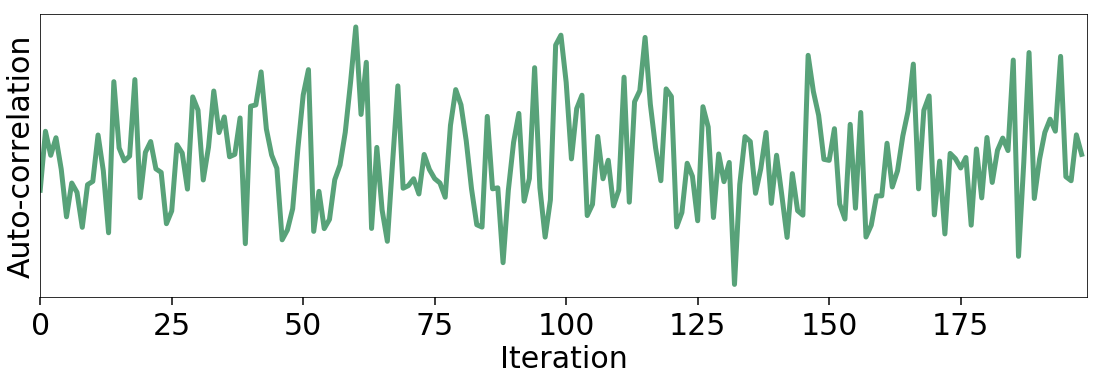

In [25]:
# plot lag=1 autocorrelation
plt.figure(figsize=(16, 6))
autocorr = np.array([np.correlate(pos[i], pos[i+1])
                     for i in range(len(pos) - 1)]).flatten()
plt.plot(autocorr, lw=5, color='seagreen', alpha=0.8)
plt.xlabel('Iteration')
plt.xlim([0., len(pos) - 1])
plt.yticks([])
plt.ylabel('Auto-correlation')
plt.tight_layout()

It looks like we effectively burn in almost immediately.

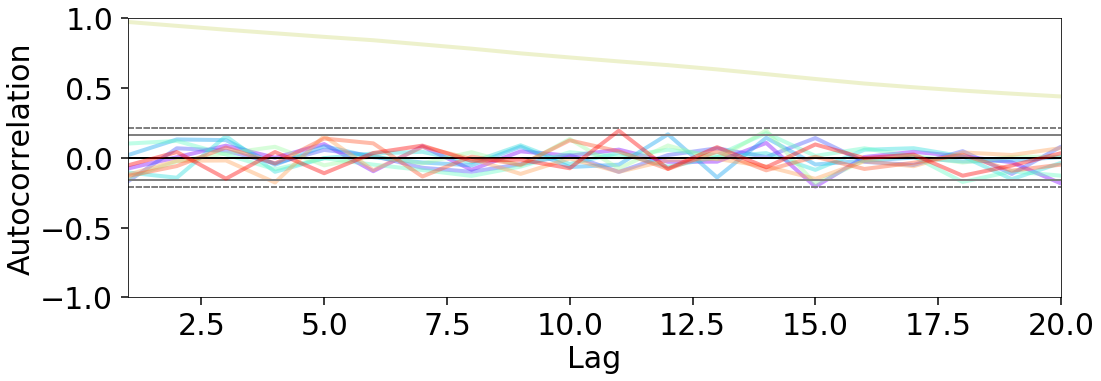

In [26]:
from pandas.plotting import autocorrelation_plot

# plot autocorrelation lag
Nburnin = 50
Nplot = 10
plt.figure(figsize=(16, 6))
colors = plt.get_cmap('rainbow')(np.linspace(0., 1., Nplot))
idxs = np.random.choice(Ngrid, size=Nplot, replace=False)
[autocorrelation_plot(pos[Nburnin:, i], 
                      color=c, lw=4, alpha=0.4) 
 for i, c in zip(idxs, colors)]
plt.xlim([1, 20])
plt.tight_layout()

Once we burn in, our auto-correlation length is quite small.

Finally, let's see what some of our $\alpha_h$'s are doing.

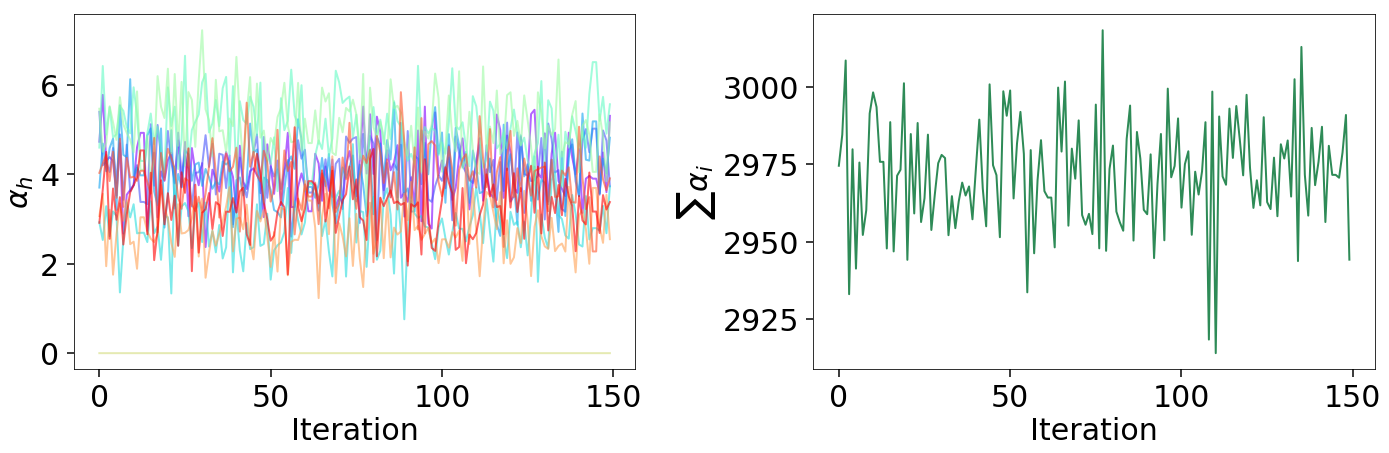

In [27]:
# plot alpha trace
plt.figure(figsize=(20, 7))
plt.subplot(1,2,1)
[plt.plot(pos[Nburnin:, i], color=c, alpha=0.6, lw=2) 
 for i,c in zip(idxs, colors)];
plt.xlabel('Iteration')
plt.ylabel(r'$\alpha_h$')
plt.tight_layout()
plt.subplot(1,2,2)
plt.plot(np.sum(pos[Nburnin:], axis=1), lw=2, color='seagreen')
plt.xlabel('Iteration')
plt.ylabel(r'$\sum \alpha_i$')
plt.tight_layout()

## Sampling from the Joint Distribution

In [28]:
# define our HMC-in-Gibbs sampler

def mcmc_hmc_in_gibbs(pdfs, Nsamples, Ngrid,
                      lnprobfn, gradfn, hessfn,
                      Nburn=0, Nthin=1,
                      Nhmc=10, L=50, epsilon=0.05,
                      verbose=True):
    """Using MCMC with HMC-in-Gibbs sampling to sample from
    the joint distribution of our hierarchical model."""
    
    Nobs = len(pdfs)
    samples_pi = np.zeros((Nsamples, Ngrid))
    samples_n = np.zeros((Nsamples, Ngrid), dtype='int')
    samples_alpha = np.zeros((Nsamples, Ngrid))

    prior = np.ones(Ngrid)  # initialize weights
    alpha = scale.copy()  # initialize alpha
    for j in range(Nthin * (Nsamples + Nburn)):
        count = int(j / Nthin) - Nburn
        if verbose and (j + 1) % Nthin == 0: 
            sys.stderr.write('{0} '.format(count))

        # Compute new posterior.
        nstack = np.zeros(Ngrid)
        pdf_t = pdfs * prior
        pdf_t /= pdf_t.sum(axis=1)[:, None]

        # Stack posterior.
        for i in range(Nobs):
            nstack += np.random.multinomial(1, pdf_t[i])

        # Sample population weights.
        prior = np.random.dirichlet(nstack + alpha) * Nobs + 1e-5
        
        # Sample concentration parameters.
        mass = -hessfn(alpha)  # mass = -hessian
        mass_inv = np.linalg.inv(mass)  # inverse mass matrix
        pos, lnp = hmc_sampler(alpha, Nhmc, L, epsilon, mass, 
                               mass_inv, lnprobfn, gradfn)
        alpha = pos[-1]

        # Save samples.
        if (j + 1) % Nthin == 0 and count >= 0:
            samples_n[count] = nstack.copy()
            samples_pi[count] = prior.copy()
            samples_alpha[count] = alpha.copy()
            
    return samples_n, samples_pi, samples_alpha

As in 2.2, let's first build up some intuition.

In [29]:
# sample from our 2-level hierarchical model
results = mcmc_hmc_in_gibbs(zpdf, 200, Ngrid, 
                            lnpost, grad_lnp, hess_lnp,
                            Nburn=0, Nthin=1, Nhmc=7,
                            L=20, epsilon=0.1)
pdf5_samples_n, pdf5_samples_pi, pdf5_samples_alpha = results

0 /home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: covariance is not positive-semidefinite.
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

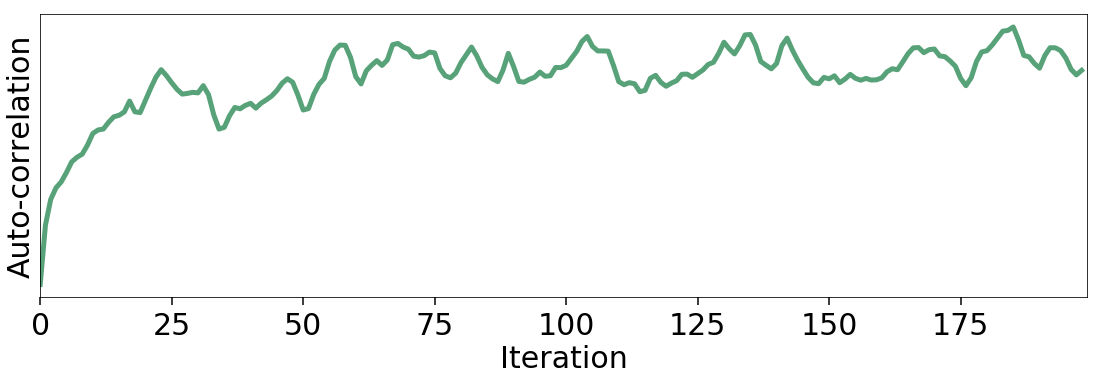

In [30]:
# plot lag=1 autocorrelation
plt.figure(figsize=(16, 6))
autocorr = np.array([np.correlate(pdf5_samples_n[i], pdf5_samples_n[i+1])
                     for i in range(len(pdf5_samples_n) - 1)]).flatten()
plt.plot(autocorr, lw=5, color='seagreen', alpha=0.8)
plt.xlabel('Iteration')
plt.xlim([0., len(pdf5_samples_n) - 1])
plt.yticks([])
plt.ylabel('Auto-correlation')
plt.tight_layout()

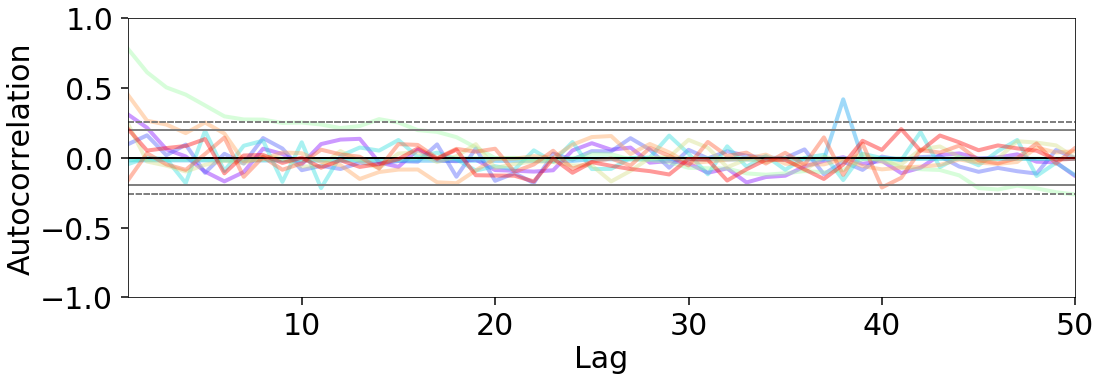

In [31]:
# plot autocorrelation lag
Nburnin = 100
Nplot = 10
plt.figure(figsize=(16, 6))
colors = plt.get_cmap('rainbow')(np.linspace(0., 1., Nplot))
idxs = np.random.choice(len(zgrid), size=Nplot, replace=False)
[autocorrelation_plot(pdf5_samples_pi[Nburnin:, i], 
                      color=c, lw=4, alpha=0.4) 
 for i, c in zip(idxs, colors)]
plt.xlim([1, (len(pdf5_samples_n) - Nburnin) / 2])
plt.tight_layout()

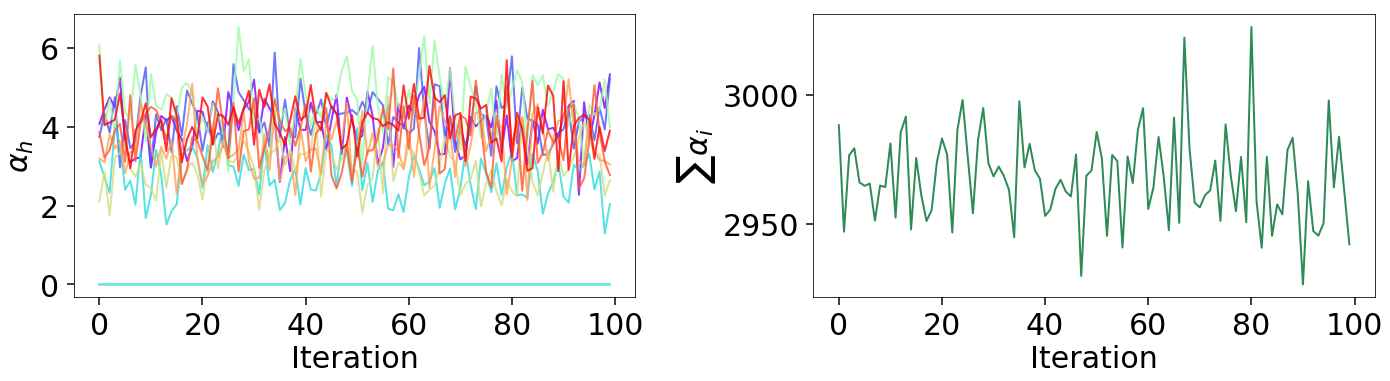

In [32]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
[plt.plot(pdf5_samples_alpha[Nburnin:, i], color=c, 
          lw=2, alpha=0.8) 
 for i,c in zip(idxs, colors)];
plt.xlabel('Iteration')
plt.ylabel(r'$\alpha_h$')
plt.tight_layout()
plt.subplot(1, 2, 2)
plt.plot(np.sum(pdf5_samples_alpha[Nburnin:], axis=1), 
         lw=2, color='seagreen')
plt.xlabel('Iteration')
plt.ylabel(r'$\sum \alpha_i$')
plt.tight_layout()

Now let's collect our samples!

In [33]:
# sample from our 2-level hierarchical model
results = mcmc_hmc_in_gibbs(zpdf, Nsamples, Ngrid, 
                            lnpost, grad_lnp, hess_lnp,
                            Nburn=40, Nthin=5, Nhmc=7,
                            L=20, epsilon=0.1)
pdf5_samples_n, pdf5_samples_pi, pdf5_samples_alpha = results

/home/joshspeagle/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: covariance is not positive-semidefinite.
-40 -39 -38 -37 -36 -35 -34 -33 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

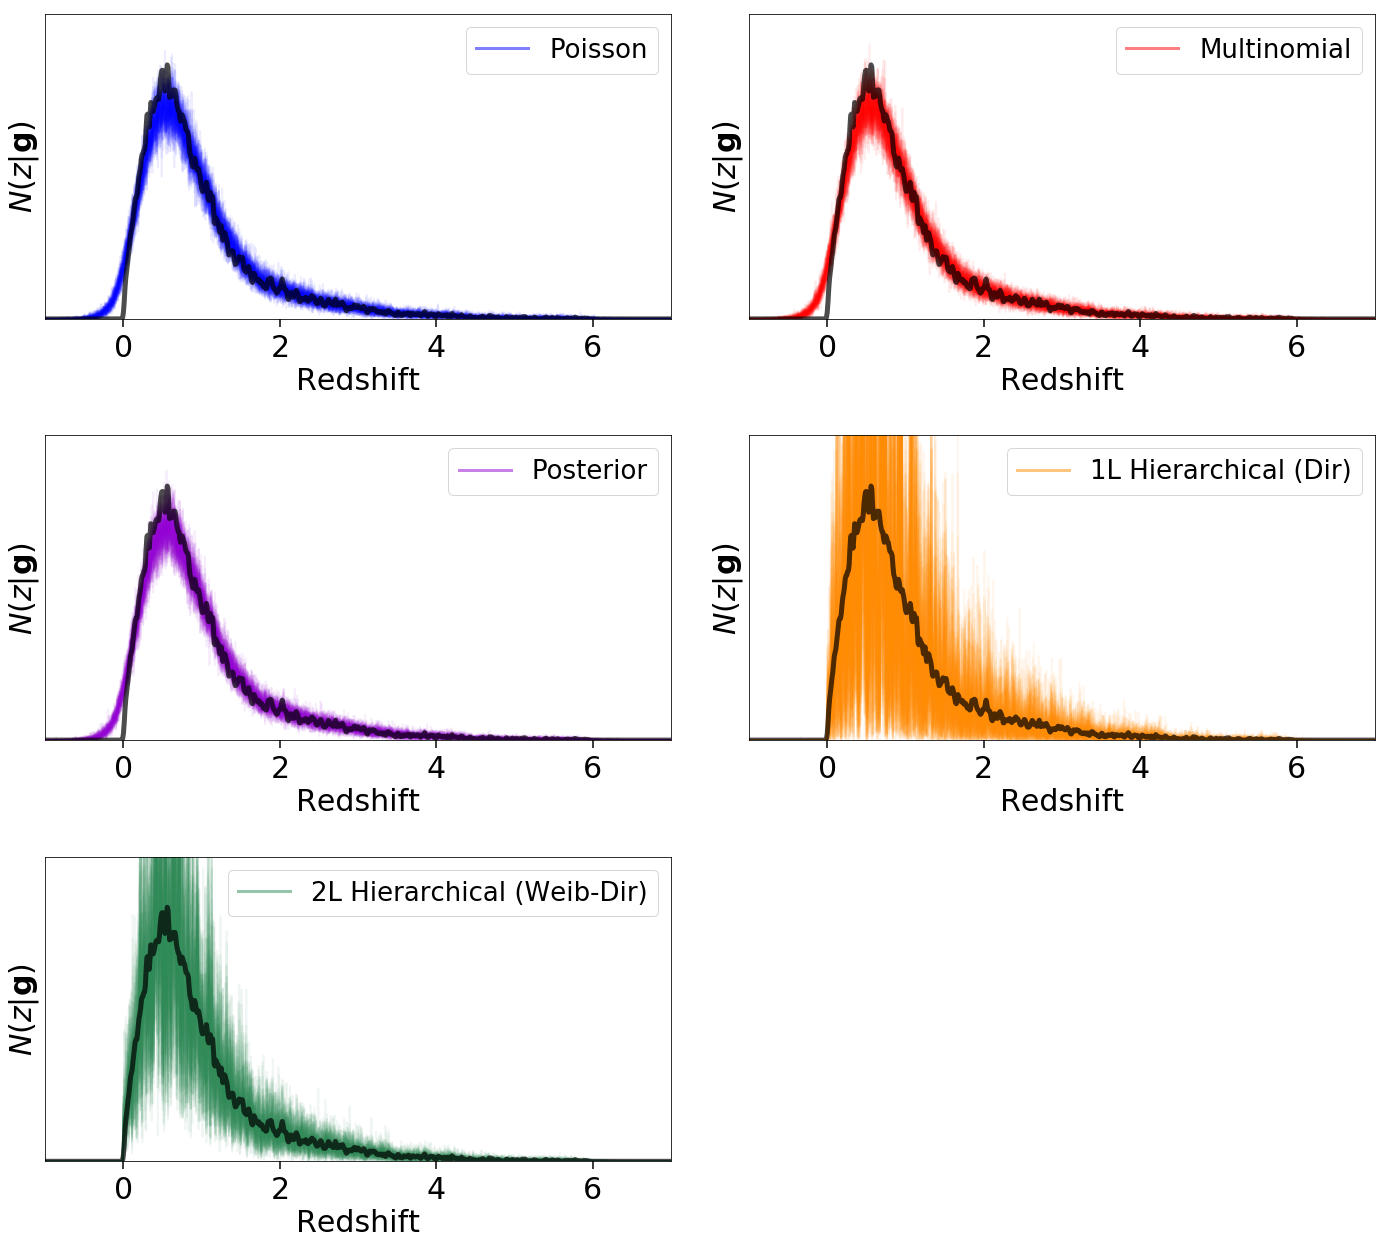

In [34]:
# plotting
plt.figure(figsize=(20, 18))
plt.subplot(3, 2, 1)
zplot(pdf1_samples, label='Poisson', color='blue')
plt.subplot(3, 2, 2)
zplot(pdf2_samples, label='Multinomial', color='red')
plt.subplot(3, 2, 3)
zplot(pdf3_samples, label='Posterior', color='darkviolet')
plt.subplot(3, 2, 4)
zplot(pdf4_samples_n, label='1L Hierarchical (Dir)', color='darkorange')
plt.subplot(3, 2, 5)
zplot(pdf5_samples_n, label='2L Hierarchical (Weib-Dir)', color='seagreen')

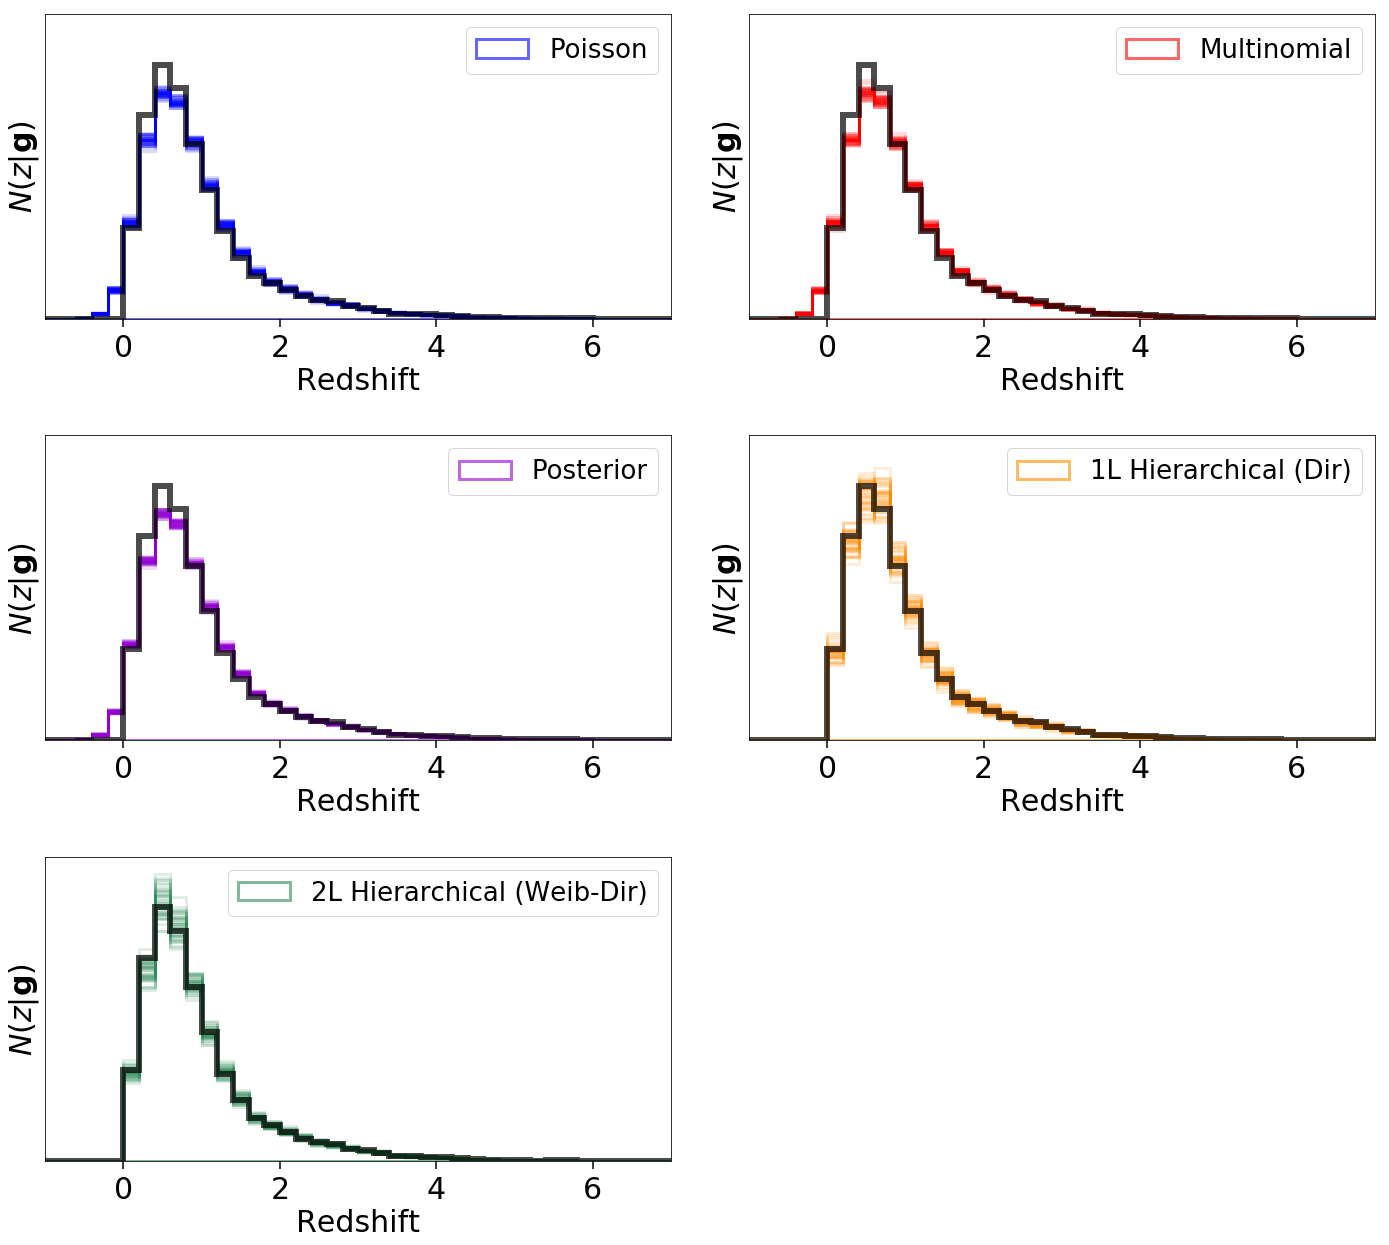

In [35]:
# plotting binned results
plt.figure(figsize=(20, 18))
plt.subplot(3, 2, 1)
zplot_bin(pdf1_samples, label='Poisson', color='blue', binning=20)
plt.subplot(3, 2, 2)
zplot_bin(pdf2_samples, label='Multinomial', color='red', binning=20)
plt.subplot(3, 2, 3)
zplot_bin(pdf3_samples, label='Posterior', color='darkviolet', binning=20)
plt.subplot(3, 2, 4)
zplot_bin(pdf4_samples_n, label='1L Hierarchical (Dir)', color='darkorange', binning=20)
plt.subplot(3, 2, 5)
zplot_bin(pdf5_samples_n, label='2L Hierarchical (Weib-Dir)', color='seagreen', binning=20)

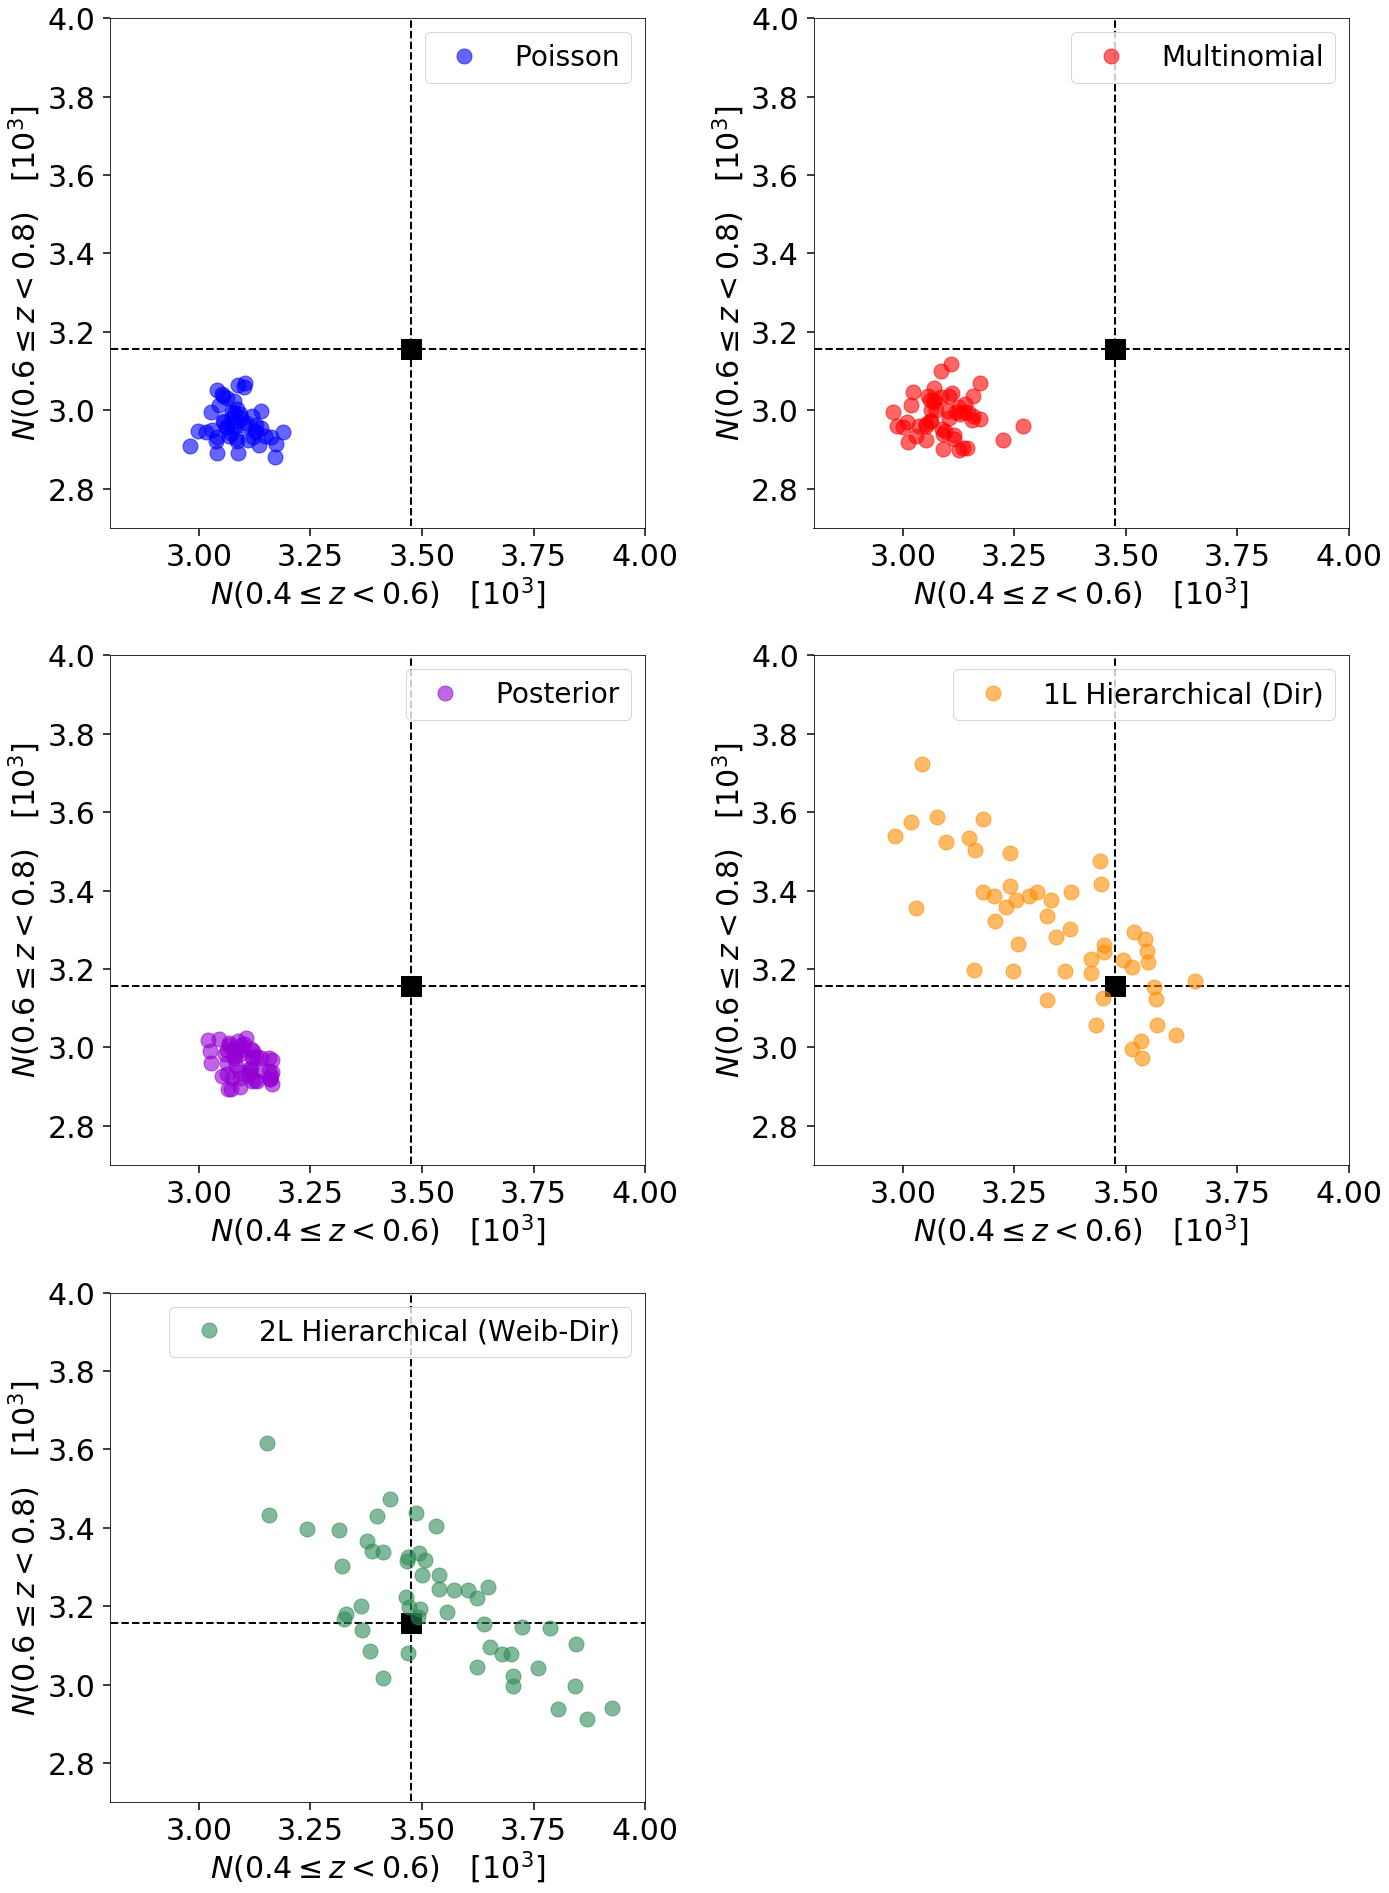

In [40]:
# plotting binned covariance
plt.figure(figsize=(20,27))
plt.subplot(3,2,1)
cov_draws(pdf1_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.8, 4.0), ylim=(2.7, 4.0),
          color='blue', label='Poisson')
plt.subplot(3,2,2)
cov_draws(pdf2_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.8, 4.0), ylim=(2.7, 4.0),
          color='red', label='Multinomial')
plt.subplot(3,2,3)
cov_draws(pdf3_samples, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.8, 4.0), ylim=(2.7, 4.0),
          color='darkviolet', label='Posterior')
plt.subplot(3,2,4)
cov_draws(pdf4_samples_n, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.8, 4.0), ylim=(2.7, 4.0),
          color='darkorange', label='1L Hierarchical (Dir)')
plt.subplot(3,2,5)
cov_draws(pdf5_samples_n, bin1=(140, 160), bin2=(160, 180),
          xlim=(2.8, 4.0), ylim=(2.7, 4.0),
          color='seagreen', label='2L Hierarchical (Weib-Dir)')

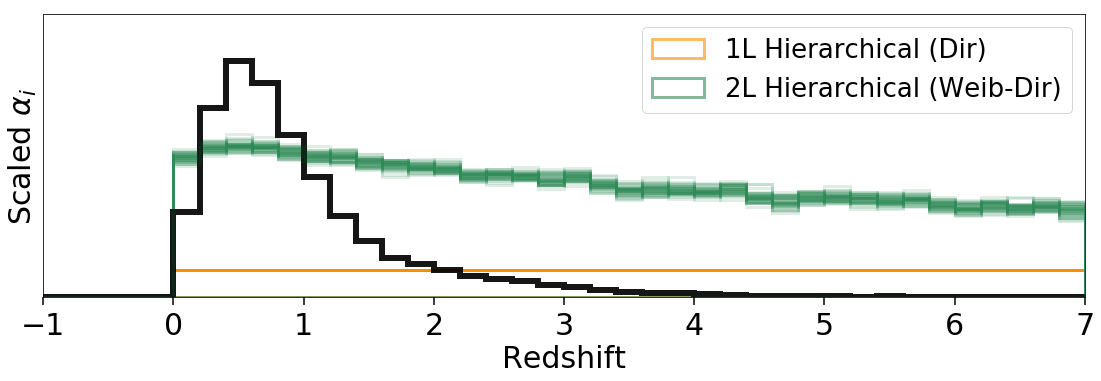

In [37]:
# plotting binned alphas
alpha = np.ones(Ngrid)
alpha[zgrid < 0.] = 1e-3
plt.figure(figsize=(16, 6))
zplot_bin(np.array([alpha for i in range(Nsamples)]) * 20, 
          label='1L Hierarchical (Dir)', color='darkorange', 
          binning=20)
zplot_bin(pdf5_samples_alpha * 20, 
          label='2L Hierarchical (Weib-Dir)', color='seagreen',
          binning=20)
plt.ylabel(r'Scaled $\alpha_i$')
plt.tight_layout()

In [38]:
# construct PDFs marginalized over the prior weights
zpdf_new = np.zeros_like(zpdf)
for prior in pdf5_samples_pi:
    zpdf_t = zpdf * prior
    zpdf_t /= np.trapz(zpdf_t, zgrid)[:, None]
    zpdf_new += zpdf_t / Nsamples

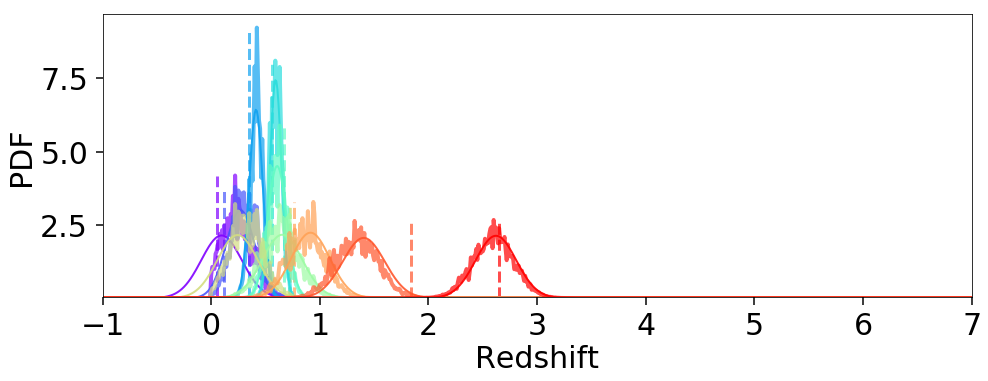

In [39]:
# plot our new PDFs
plt.figure(figsize=(14, 6))
colors = plt.get_cmap('rainbow')(np.linspace(0., 1., len(zidxs)))
for i, c in zip(zidxs, colors):
    plt.plot(zgrid, zpdf[i], color=c, lw=2, alpha=0.9)
    plt.plot(zgrid, zpdf_new[i], color=c, lw=4, alpha=0.7)
    plt.vlines(redshifts[i], 0., max(zpdf_new[i]), color=c, 
               lw=3, linestyles='--', alpha=0.7)
plt.xlim([zgrid[0], zgrid[-1]])
plt.ylim([0.03, None])
plt.xlabel('Redshift')
plt.ylabel('PDF')
plt.tight_layout()